In [198]:
from database.data_importer import DataManagement
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
import numpy as np
import seaborn as sn

# Data Import

In [199]:
dm = DataManagement()
df = dm.db_query('select * from working_data')

In [200]:
df.head()

name                              instance   value         type  log_order  \
0  1506  f7b10faa-6e79-4444-929d-40e3fc74cdce  active        state          0   
1  1506  f7b10faa-6e79-4444-929d-40e3fc74cdce   77.72  measurement          1   
2  1506  f7b10faa-6e79-4444-929d-40e3fc74cdce   77.71  measurement          2   
3  1506  f7b10faa-6e79-4444-929d-40e3fc74cdce    77.7  measurement          3   
4  1506  f7b10faa-6e79-4444-929d-40e3fc74cdce   77.69  measurement          4   

                       timestamp batch parent_id m_name m_instance  \
0  2020-11-03T18:48:43.060+01:00    10      None   None       None   
1  2020-11-03T18:48:43.062+01:00    10      None   None       None   
2  2020-11-03T18:48:43.085+01:00    10      None   None       None   
3  2020-11-03T18:48:43.139+01:00    10      None   None       None   
4  2020-11-03T18:48:43.178+01:00    10      None   None       None   

  upright_value lying_value m_file  
0          None        None   None  
1          None        None   None  
2          None        None   None  
3          None        None   None  
4          None        None   None

In [201]:
df_raw = df.query('type == "measurement"') 
df_raw = df_raw.astype({'value': float, 'batch':int})
df_raw['timestamp'] = pd.to_datetime(df_raw['timestamp'])
df_raw.head()

name                              instance  value         type  log_order  \
1  1506  f7b10faa-6e79-4444-929d-40e3fc74cdce  77.72  measurement          1   
2  1506  f7b10faa-6e79-4444-929d-40e3fc74cdce  77.71  measurement          2   
3  1506  f7b10faa-6e79-4444-929d-40e3fc74cdce  77.70  measurement          3   
4  1506  f7b10faa-6e79-4444-929d-40e3fc74cdce  77.69  measurement          4   
5  1506  f7b10faa-6e79-4444-929d-40e3fc74cdce  77.68  measurement          5   

                          timestamp  batch parent_id m_name m_instance  \
1  2020-11-03 18:48:43.062000+01:00     10      None   None       None   
2  2020-11-03 18:48:43.085000+01:00     10      None   None       None   
3  2020-11-03 18:48:43.139000+01:00     10      None   None       None   
4  2020-11-03 18:48:43.178000+01:00     10      None   None       None   
5  2020-11-03 18:48:43.201000+01:00     10      None   None       None   

  upright_value lying_value m_file  
1          None        None   None  
2          None        None   None  
3          None        None   None  
4          None        None   None  
5          None        None   None

# Function definitions

## Data retrieval

In [202]:
def get_batch_data(batches):
    return df_raw[df_raw['batch'].isin(batches)]

## Plotting

### Heatmap plot

In [203]:
def plot_heatmap(data):
    fig, ax = plt.subplots(figsize=(10,10))
    sn.heatmap(data, cmap='RdYlGn', square = False, xticklabels = data.columns)

### Instance data visualization

In [204]:
def plot_instance_data(grouped_data, x, y, n_cols, figsize, kind = 'line', title = None):
    # Calculate row/column indices for subplots
    #cols = list(range(n_cols))
    n_rows = int(np.ceil(len(grouped_data) / n_cols))
    #rows = list(range(n_rows))
    #indices = [(x, y) for x in rows for y in cols]
    #indices = indices[:45]
    # Set up basic figure
    fig, axs = plt.subplots(nrows = n_rows, ncols = n_cols, sharex = True, sharey = True, figsize = figsize)
    if not title is None:
        fig.suptitle(title)
    instances = grouped_data.apply(lambda x: x.name).to_list()
    for (key, ax) in zip(instances, axs.flatten()):
        #if x is None or y is None:
            #grouped_data.get_group(key).plot(kind = kind, ax=ax, legend = None)
        #else:
        grouped_data.get_group(key).plot(kind = kind, x = x, y = y, ax=ax, legend = None)
        ax.set_title(key, fontdict = {'fontsize':8})
    plt.show()

# Data preparation

Since the different measurement processes of course did not take place at the same time, we can normalize the measurement timestamps for each distinct process instance to facilitate later comparison.

In [205]:
# Normalize the measurement timestamps
df_raw['timestamp'] = (df_raw['timestamp'] - df_raw.groupby('instance')['timestamp'].transform('min'))
df_raw['timestamp'] = pd.to_timedelta(df_raw['timestamp'])

In [206]:
instance_measurements = df_raw.groupby('instance', sort = False)[['value', 'timestamp', 'log_order', 'batch', 'upright_value']]

# Upsample data points to intervals of 5 ms
resampled_data = instance_measurements.apply(lambda x: x.drop_duplicates(subset='timestamp', keep='first').set_index('timestamp').resample('100L').pad())
resampled_data = resampled_data.reset_index()

df_raw = resampled_data
df_raw.head()

instance              timestamp  value  \
0  f7b10faa-6e79-4444-929d-40e3fc74cdce        0 days 00:00:00  77.72   
1  f7b10faa-6e79-4444-929d-40e3fc74cdce 0 days 00:00:00.100000  77.70   
2  f7b10faa-6e79-4444-929d-40e3fc74cdce 0 days 00:00:00.200000  77.60   
3  f7b10faa-6e79-4444-929d-40e3fc74cdce 0 days 00:00:00.300000  77.04   
4  f7b10faa-6e79-4444-929d-40e3fc74cdce 0 days 00:00:00.400000  76.86   

   log_order  batch upright_value  
0          1     10          None  
1          3     10          None  
2         12     10          None  
3         36     10          None  
4         49     10          None

In [207]:
# Working with given batches
batches = [7, 8, 9]
data = get_batch_data(batches)

## Ground truth - Good parts according MicroVu measurements
For later comparison, the outcome of the MicroVu measurement is taken into account as ground truth.
We will just take the standing ones as reference due to the week performance of the laying measurements, as has been shown by Group 5.

In [208]:
all_instances = np.unique(data['instance'])
good_parts_microvu = data.query("upright_value == 'True'")
good_instances = np.unique(good_parts_microvu['instance'])

heatmap_data = [0.5 if x == None else x in good_instances for x in all_instances]
        
reference_instances = pd.Series(heatmap_data, index = all_instances)
reference_instances.sort_index(inplace = True)

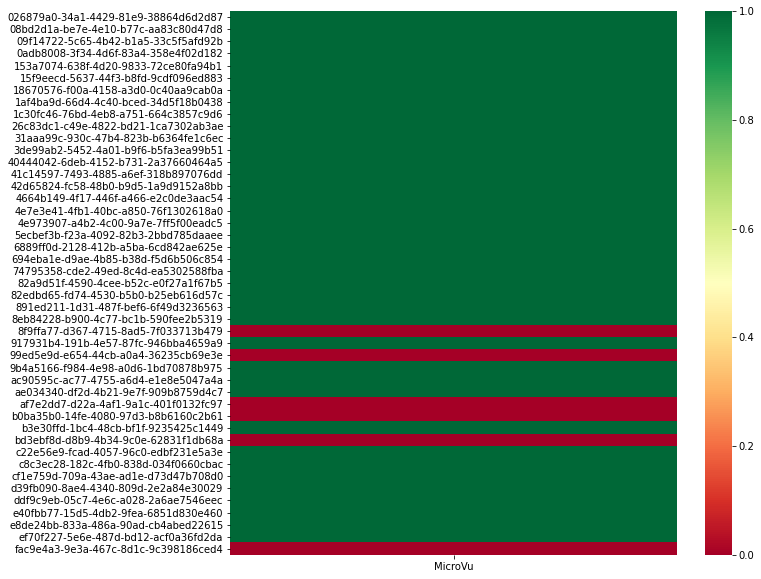

In [209]:
classification_results = reference_instances.to_frame(name = 'MicroVu')
plot_heatmap(classification_results)

# Data exploration

### Grouping data by instance

In [210]:
# Group the measurements based on the process instance id
instance_measurements = data.groupby('instance', sort = False)[['value', 'timestamp']]

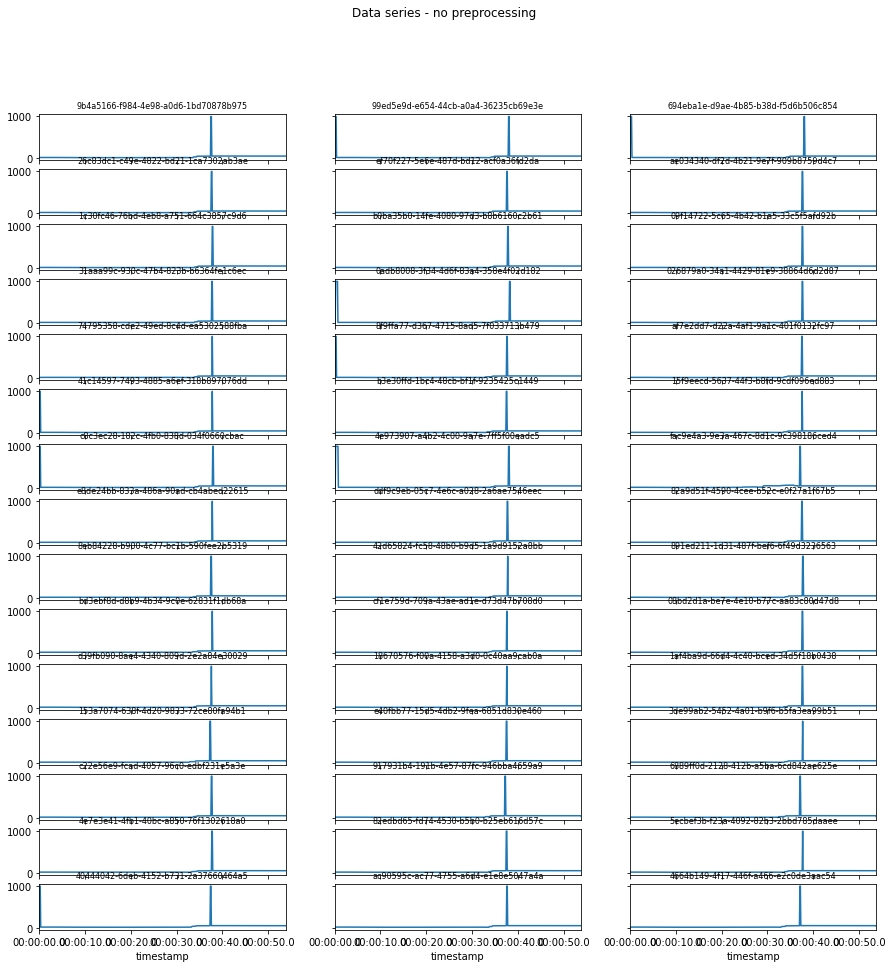

In [211]:
# First plot of all data series
plot_instance_data(instance_measurements, x = 'timestamp', y = 'value', n_cols = 3, figsize = (15, 15), title = "Data series - no preprocessing")

__Plot outcome - Takeaway:__<br>
The big spikes occuring in every series are a first issue that must be tackled. We've heard these are due to ledges that are observed during the measuring process. They should come from 'chips' on the rook, as the parts are not perfectly clean upon this measurement process via the Keyence. Note for possibly future issues: Oil/Kühlemulsion may also interfere the measurement!

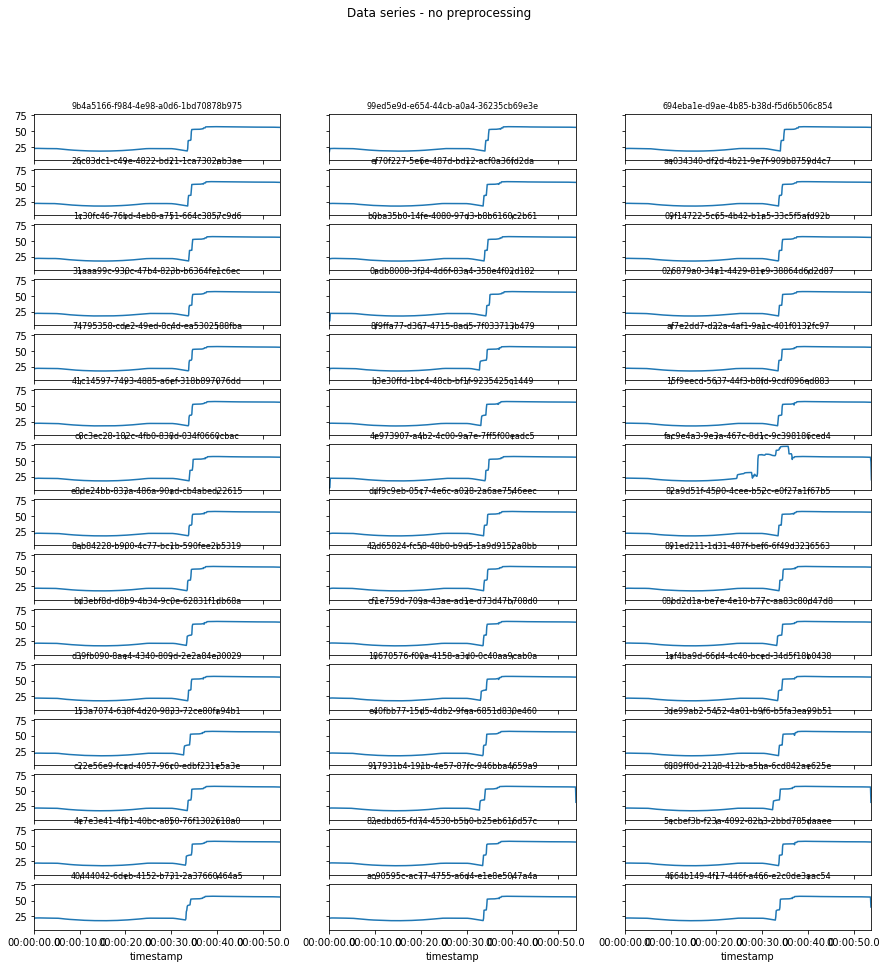

In [212]:
# Filter out spikes from the series to remove faulty measurements coming from ledges
df = data
df['value'] = df['value'].where(df['value'] < 999).fillna(method='bfill')

# Normalize the measurement timestamps
df['timestamp'] = (df['timestamp'] - df.groupby('instance')['timestamp'].transform('min'))

# Group measurement data according to process instance
instance_measurements = df.groupby('instance', sort = False)[['value', 'timestamp', 'log_order']]

plot_instance_data(instance_measurements, x = 'timestamp', y = 'value', n_cols = 3, figsize = (15, 15), title = "Data series - no preprocessing")

__Plot outcome - Takeaway:__<br>
The removal of the ledge spikes now provides a better picture on the different data series. By intuition one would say the data series of process instance _'fac9e4a3-9e3a-467c-8d1c-9c398186ced4'_ probably shows a faulty rook. We can check that.<br>
<br>
Also, some data series show some suspicious low measurements (data points) right in the beginning. We can filter out these measurements and plot the data again.

In [213]:
#reference_instances['fac9e4a3-9e3a-467c-8d1c-9c398186ced4']

As we already assumed, the rook measured in process instance _'fac9e4a3-9e3a-467c-8d1c-9c398186ced4'_ is faulty.

In [214]:
data.head()

instance              timestamp  value  \
2705  9b4a5166-f984-4e98-a0d6-1bd70878b975        0 days 00:00:00  22.10   
2706  9b4a5166-f984-4e98-a0d6-1bd70878b975 0 days 00:00:00.100000  22.17   
2707  9b4a5166-f984-4e98-a0d6-1bd70878b975 0 days 00:00:00.200000  22.23   
2708  9b4a5166-f984-4e98-a0d6-1bd70878b975 0 days 00:00:00.300000  22.29   
2709  9b4a5166-f984-4e98-a0d6-1bd70878b975 0 days 00:00:00.400000  22.33   

      log_order  batch upright_value  
2705          1      7          True  
2706          8      7          True  
2707         14      7          True  
2708         20      7          True  
2709         24      7          True

In [215]:
# Making diff for value series
def find_spikes(group_data):
    df = group_data
    delta = 999
    i = 1
    while delta > 0 and i < 5:
        df['index'] = np.arange(0, len(df), 1)
        df['delta_1'] = abs(df['value'].diff(periods = -2))
        df['delta_2'] = abs(df['value'].diff(periods = 2))
        filter_1 = df['delta_1'] < 0.02
        filter_2 = df['delta_2'] < 0.02
        df = df.where((filter_1 & filter_2) | (df['index'] > 10)).dropna()
        rows = df.head(4)
        delta_1 = max(rows['delta_1'])
        delta_2 = max(rows['delta_2'])
        delta = max(delta_1, delta_2)
        i = i + 1
    return df

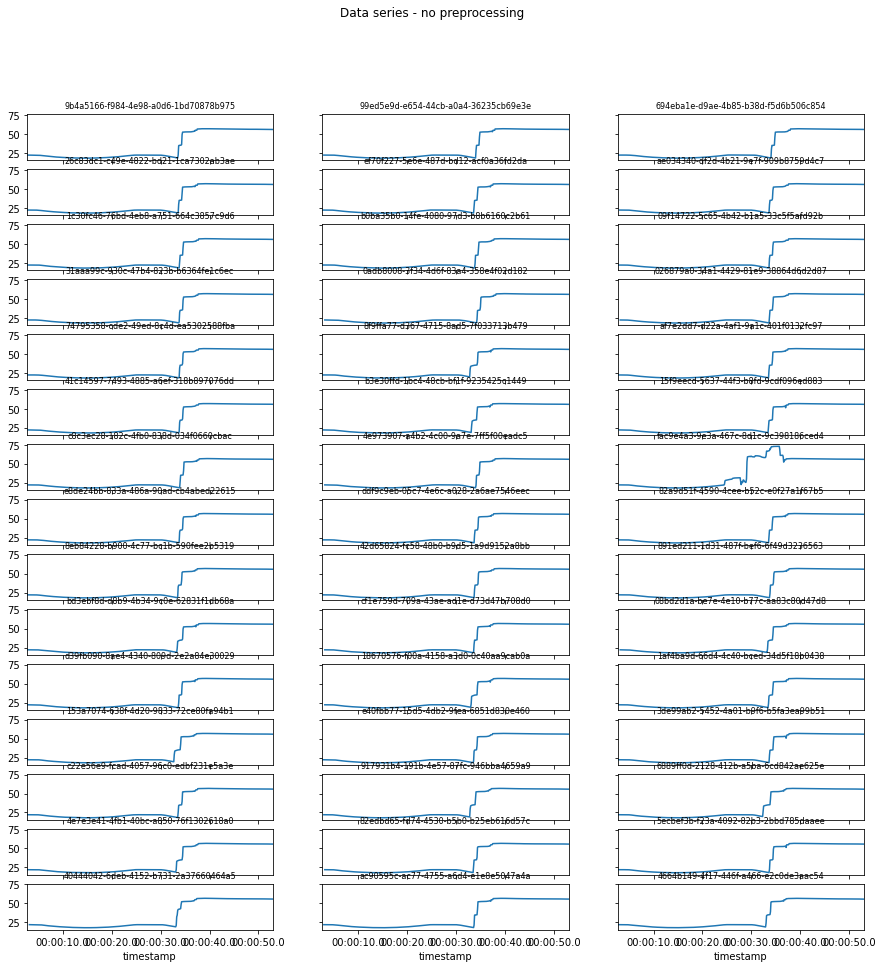

In [216]:
# Group measurement data according to process instance
#instance_measurements = df.groupby('instance', sort = False)[['value', 'timestamp', 'log_order']]

cleaned_measurements = instance_measurements.apply(find_spikes).reset_index()
cleaned_measurements.drop('level_1', axis = 1, inplace = True)
instance_measurements = cleaned_measurements.groupby('instance', sort = False)[['value', 'timestamp']]

plot_instance_data(instance_measurements, x = 'timestamp', y = 'value', n_cols = 3, figsize = (15, 15), title = "Data series - no preprocessing")

In [217]:
instance_measurements.apply(print)

     value              timestamp
0    22.04 0 days 00:00:02.800000
1    22.03 0 days 00:00:02.900000
2    22.03        0 days 00:00:03
3    22.03 0 days 00:00:03.100000
4    22.03 0 days 00:00:03.200000
..     ...                    ...
503  55.76 0 days 00:00:53.100000
504  55.74 0 days 00:00:53.200000
505  55.72 0 days 00:00:53.300000
506  55.72 0 days 00:00:53.400000
507  55.72 0 days 00:00:53.500000

[508 rows x 2 columns]
      value              timestamp
508   22.03        0 days 00:00:03
509   22.03 0 days 00:00:03.100000
510   22.03 0 days 00:00:03.200000
511   22.03 0 days 00:00:03.300000
512   22.03 0 days 00:00:03.400000
...     ...                    ...
1013  55.76 0 days 00:00:53.500000
1014  55.74 0 days 00:00:53.600000
1015  55.72 0 days 00:00:53.700000
1016  55.72 0 days 00:00:53.800000
1017  55.72 0 days 00:00:53.900000

[510 rows x 2 columns]
      value              timestamp
1018  22.03 0 days 00:00:02.900000
1019  22.02        0 days 00:00:03
1020  22.02 0 days 

[511 rows x 2 columns]
       value              timestamp
14257  22.03 0 days 00:00:03.200000
14258  22.03 0 days 00:00:03.300000
14259  22.02 0 days 00:00:03.400000
14260  22.02 0 days 00:00:03.500000
14261  22.03 0 days 00:00:03.600000
...      ...                    ...
14756  55.75 0 days 00:00:53.100000
14757  55.73 0 days 00:00:53.200000
14758  55.71 0 days 00:00:53.300000
14759  55.71 0 days 00:00:53.400000
14760  55.71 0 days 00:00:53.500000

[504 rows x 2 columns]
       value              timestamp
14761  22.03 0 days 00:00:03.200000
14762  22.02 0 days 00:00:03.300000
14763  22.02 0 days 00:00:03.400000
14764  22.02 0 days 00:00:03.500000
14765  22.03 0 days 00:00:03.600000
...      ...                    ...
15260  55.75 0 days 00:00:53.100000
15261  55.73 0 days 00:00:53.200000
15262  55.71 0 days 00:00:53.300000
15263  55.70 0 days 00:00:53.400000
15264  55.70 0 days 00:00:53.500000

[504 rows x 2 columns]
       value              timestamp
15265  22.04 0 days 00:00:02.

Empty DataFrame
Columns: []
Index: []

<AxesSubplot:>

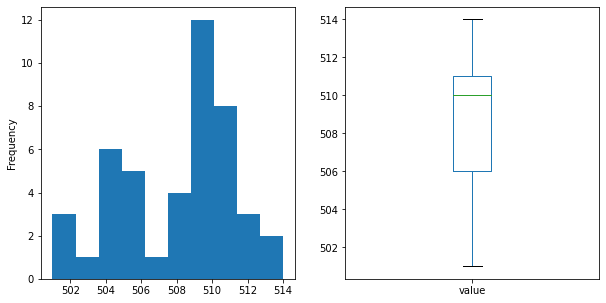

In [218]:
data_point_counts = instance_measurements.count()['value']

fig, ax = plt.subplots(ncols = 2, figsize=(10,5))

# Plot data point count as histogram
data_point_counts.plot(kind = 'hist', ax = ax[0])

# Plot data point count as boxplot
data_point_counts.plot(kind = 'box', ax = ax[1])

The plots show that the measurements are containing about 1800-1900 single data points normally.<br>
However, there is a single outlier, that comes with more than 2700 data points.

In [219]:
data_point_counts.sort_values(ascending = False).head(1)

instance
4e7e3e41-4fb1-40bc-a850-76f1302618a0    514
Name: value, dtype: int64

It can be seen, that the outlier here is coming from the already known faulty rook (process instance _'fac9e4a3-9e3a-467c-8d1c-9c398186ced4'_).

### Duration of measurement process

We can check out the duration of the measurement process for the single rooks.<br>
Maybe it's possible to find a relation between amount of data points and general time duration.

<AxesSubplot:ylabel='Frequency'>

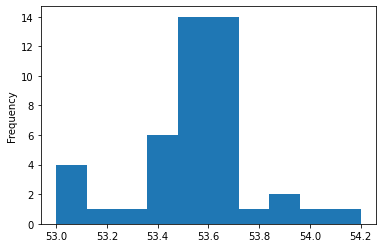

In [220]:
# Calculate total time duration of the measurement processes
times = instance_measurements.apply(lambda x: x['timestamp'].dt.total_seconds().max())

# Plot times in a histogram
times.plot(kind = 'hist')

# Cluster analysis

## Data preparation

I'm taking the data that has been prepared in the previous section as basis.

In [265]:
data = instance_measurements

<AxesSubplot:ylabel='Frequency'>

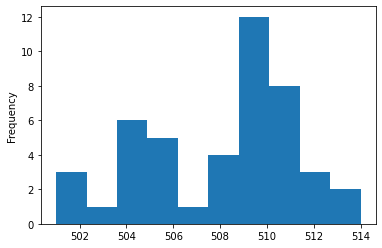

In [266]:
data.count()['value'].plot(kind = 'hist')

In [267]:
time_deltas = data.apply(lambda x: np.median(x['timestamp'].diff())).to_list()
time_resolution = np.median(time_deltas)

In [268]:
begin_times = data.apply(lambda x: x['timestamp'].min())
begin_time = np.median(begin_times)

max_count = data.count()['value'].min()
max_timedelta = time_resolution * (max_count - 1) + begin_time

freq = str(time_resolution.microseconds) + 'U'

begin_time = pd.to_timedelta(0, unit = 'S')

time_range = pd.timedelta_range(begin_time, max_timedelta, freq = freq)

clustering_input = data.apply(lambda x: x.set_index('timestamp').reindex(time_range, method = 'bfill')).reset_index()
clustering_input.rename(columns = {'level_1':'timestamp'}, inplace = True)
clustering_input = clustering_input.groupby('instance', sort = False)

In [269]:
clustering_input.count()#['value'].plot(kind = 'hist')

timestamp  value
instance                                              
9b4a5166-f984-4e98-a0d6-1bd70878b975        529    529
99ed5e9d-e654-44cb-a0a4-36235cb69e3e        529    529
694eba1e-d9ae-4b85-b38d-f5d6b506c854        529    529
26c83dc1-c49e-4822-bd21-1ca7302ab3ae        529    529
ef70f227-5e6e-487d-bd12-acf0a36fd2da        529    529
ae034340-df2d-4b21-9e7f-909b8759d4c7        529    529
1c30fc46-76bd-4eb8-a751-664c3857c9d6        529    529
b0ba35b0-14fe-4080-97d3-b8b6160c2b61        529    529
09f14722-5c65-4b42-b1a5-33c5f5afd92b        529    529
31aaa99c-930c-47b4-823b-b6364fe1c6ec        529    529
0adb8008-3f34-4d6f-83a4-358e4f02d182        529    529
026879a0-34a1-4429-81e9-38864d6d2d87        529    529
74795358-cde2-49ed-8c4d-ea5302588fba        529    529
8f9ffa77-d367-4715-8ad5-7f033713b479        529    529
af7e2dd7-d22a-4af1-9a1c-401f0132fc97        529    529
41c14597-7493-4885-a6ef-318b897076dd        529    529
b3e30ffd-1bc4-48cb-bf1f-9235425c1449        529    529
15f9eecd-5637-44f3-b8fd-9cdf096ed883        529    529
c8c3ec28-182c-4fb0-838d-034f0660cbac        529    529
4e973907-a4b2-4c00-9a7e-7ff5f00eadc5        529    529
fac9e4a3-9e3a-467c-8d1c-9c398186ced4        529    529
e8de24bb-833a-486a-90ad-cb4abed22615        529    529
ddf9c9eb-05c7-4e6c-a028-2a6ae7546eec        529    529
82a9d51f-4590-4cee-b52c-e0f27a1f67b5        529    529
8eb84228-b900-4c77-bc1b-590fee2b5319        529    529
42d65824-fc58-48b0-b9d5-1a9d9152a8bb        529    529
891ed211-1d31-487f-bef6-6f49d3236563        529    529
bd3ebf8d-d8b9-4b34-9c0e-62831f1db68a        529    529
cf1e759d-709a-43ae-ad1e-d73d47b708d0        529    529
08bd2d1a-be7e-4e10-b77c-aa83c80d47d8        529    529
d39fb090-8ae4-4340-809d-2e2a84e30029        529    529
18670576-f00a-4158-a3d0-0c40aa9cab0a        529    529
1af4ba9d-66d4-4c40-bced-34d5f18b0438        529    529
153a7074-638f-4d20-9833-72ce80fa94b1        529    529
e40fbb77-15d5-4db2-9fea-6851d830e460        529    529
3de99ab2-5452-4a01-b9f6-b5fa3ea99b51        529    529
c22e56e9-fcad-4057-96c0-edbf231e5a3e        529    529
917931b4-191b-4e57-87fc-946bba4659a9        529    529
6889ff0d-2128-412b-a5ba-6cd842ae625e        529    529
4e7e3e41-4fb1-40bc-a850-76f1302618a0        529    529
82edbd65-fd74-4530-b5b0-b25eb616d57c        529    529
5ecbef3b-f23a-4092-82b3-2bbd785daaee        529    529
40444042-6deb-4152-b731-2a37660464a5        529    529
ac90595c-ac77-4755-a6d4-e1e8e5047a4a        529    529
4664b149-4f17-446f-a466-e2c0de3aac54        529    529

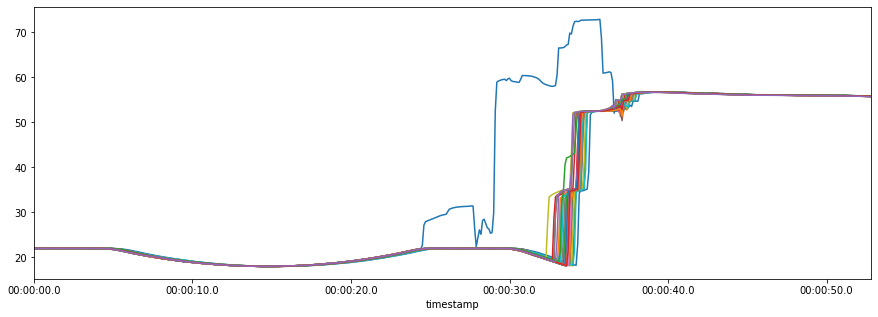

In [270]:
fig, ax = plt.subplots(figsize=(15,5))
for label, instance_data in clustering_input:
    instance_data.plot(x = 'timestamp', y = 'value', ax=ax, label=label, legend = None)
plt.show()

### Clustering Input Data

In [271]:
X = clustering_input.apply(lambda x: x['value'].to_list()).to_list()
X = np.array(X)
instances = clustering_input.apply(lambda x: x.name).to_list()

## Normal clustering approach - Traditional algorithms

## DBSCAN Clustering

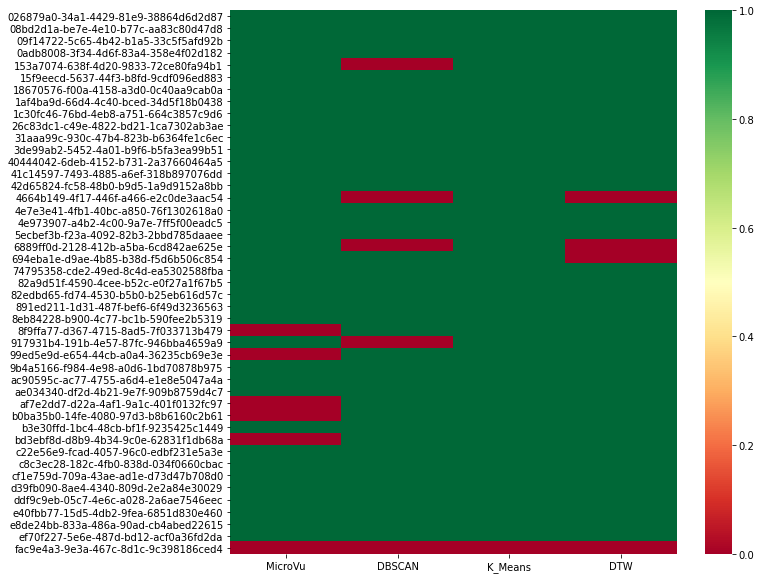

In [272]:
#db = DBSCAN(eps = 4.2807707)
db = DBSCAN(eps = 30)


labels = db.fit_predict(X)
labels

#labels = -labels
labels = labels + 1
labels = [x > 0 for x in labels]
results = pd.Series(labels, index = instances)
results.sort_index(inplace = True)
heatmap_data = classification_results
heatmap_data['DBSCAN'] = results.values
plot_heatmap(heatmap_data)

### Function definitions for later error calculation based on clustering centroids

In [273]:
def calculate_error(data, centroid):
    errors = []
    errors.append(centroid - data)
    for i in range(1, 50):
        errors.append(centroid[i:] - data[:-i])
        errors.append(centroid[:-i] - data[i:])
    summed_errors = [np.median(abs(x)) for x in errors]
    val, idx = min((val, idx) for (idx, val) in enumerate(summed_errors))
    return errors[idx]

In [274]:
def calculate_faulty_parts(error_treshold, filter_threshold, errors, clustering_labels, desired_cluster_label):
    filter_threshold = error_treshold * filter_threshold
    faults = []
    for i in range(len(errors)):
        instance_data = errors[i]
        instance_data = abs(instance_data)
        filtered =  instance_data[instance_data < filter_treshold]
        fault = filtered[filtered > error_treshold]
        if fault.any():
            faults.append(len(fault))
        else:
            faults.append(0)

    faulty_instances = []

    for instance, fault, label in zip(instances, faults, clustering_labels):
        if (fault >= 25 or label != desired_cluster_label):
            faulty_instances.append(instance)

    labels = [x not in faulty_instances for x in instances]
    return labels

In [275]:
def plot_errors(errors, target_instances):
    instance = 0
    for instance_errors in errors:
        if instance in targets:
            coordinates = np.arange(0, len(instance_errors), 1)
            plt.bar(x = coordinates, height = instance_errors)
            plt.show()
        instance = instance + 1

## K-Means Clustering

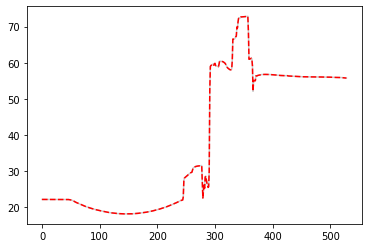

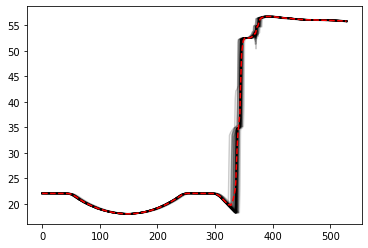

In [276]:
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
labels = kmeans.fit_predict(X)

for i in range(n_clusters):
    for xx in X[labels == i]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(kmeans.cluster_centers_[i].ravel(), "r--")
    plt.show()

#labels == 1

centroid = kmeans.cluster_centers_[1].ravel()

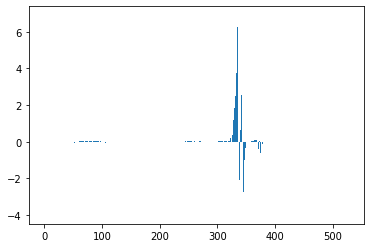

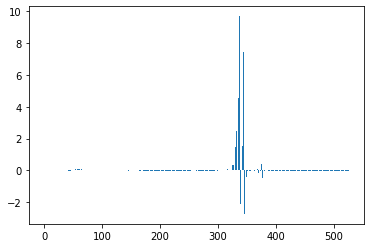

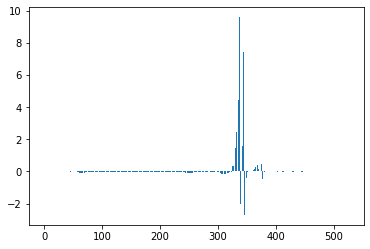

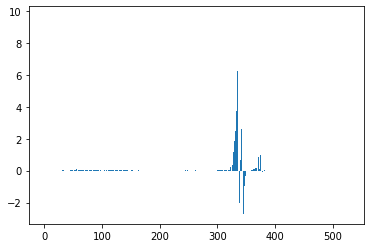

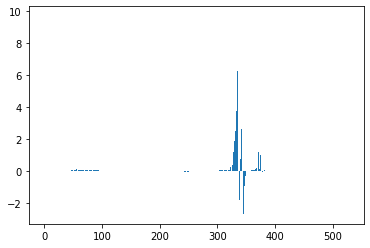

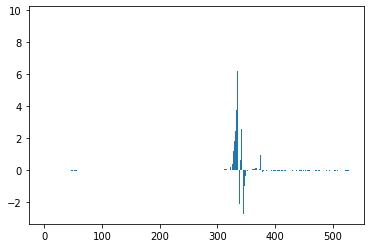

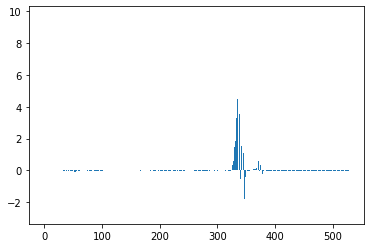

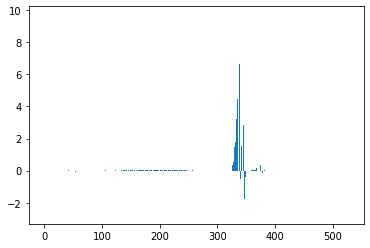

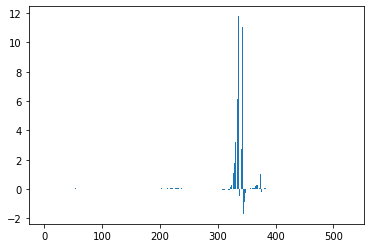

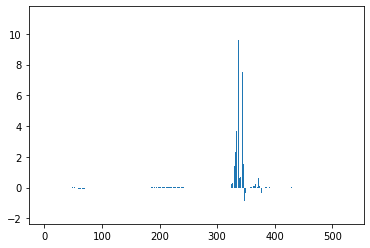

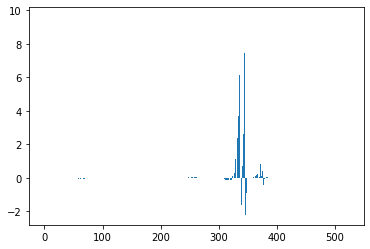

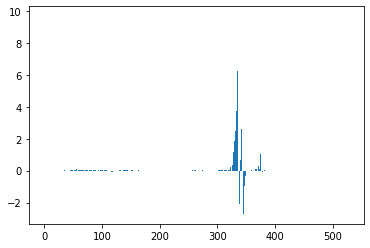

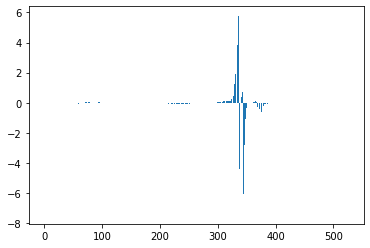

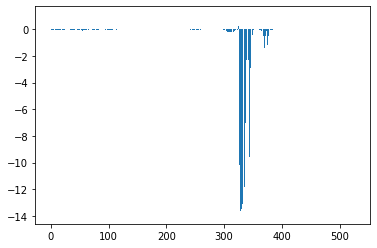

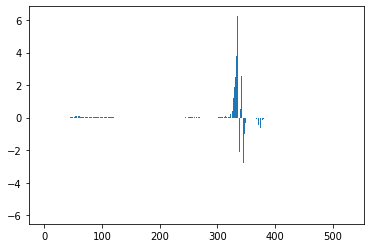

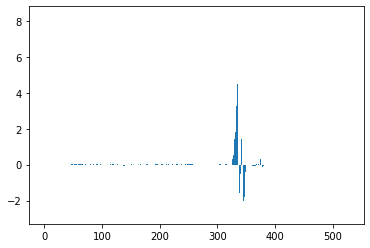

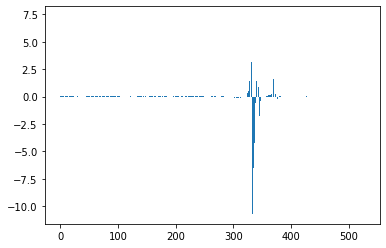

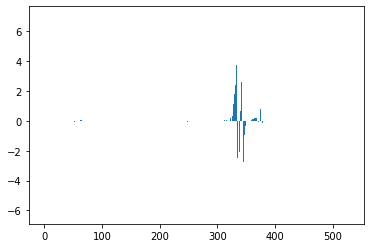

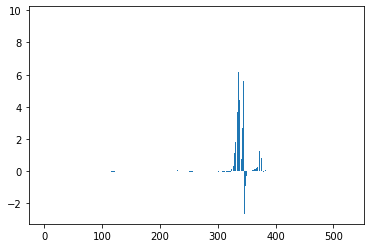

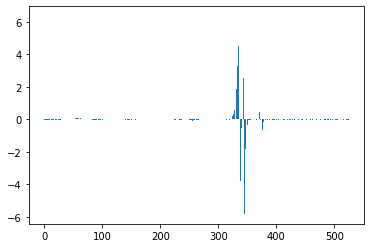

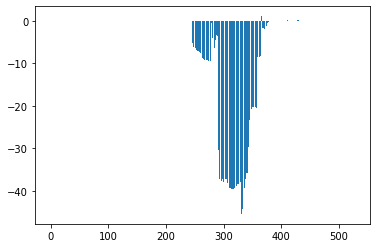

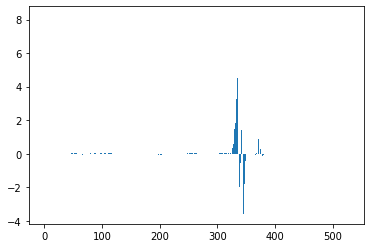

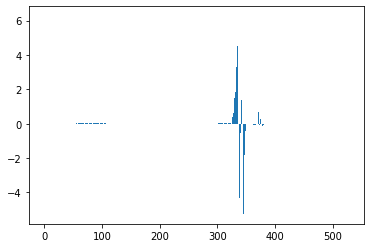

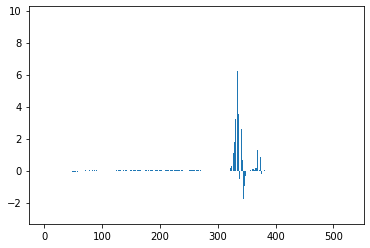

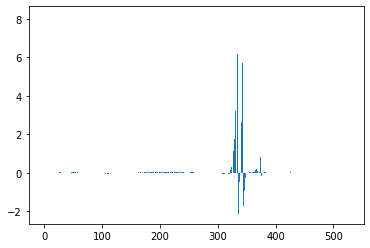

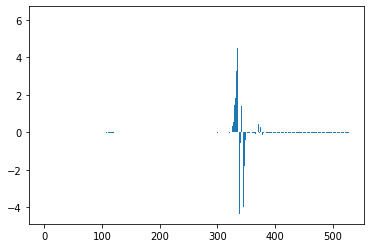

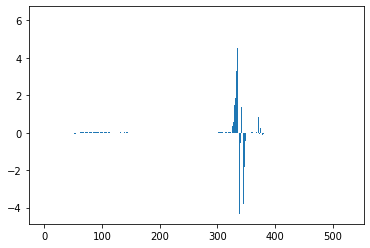

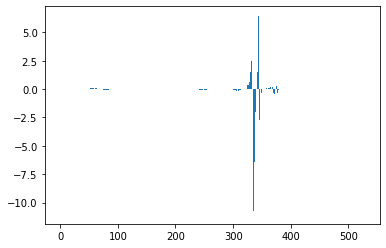

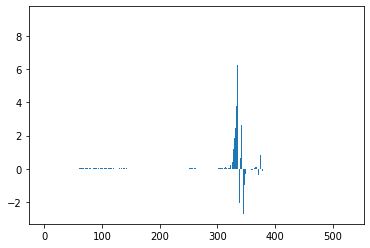

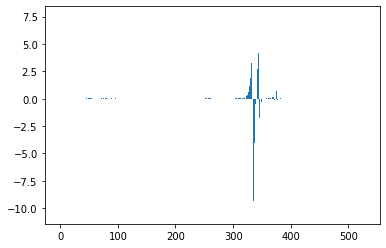

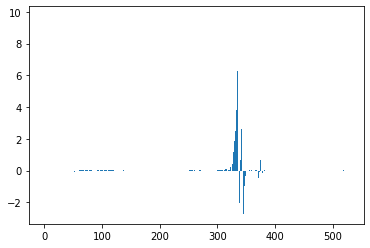

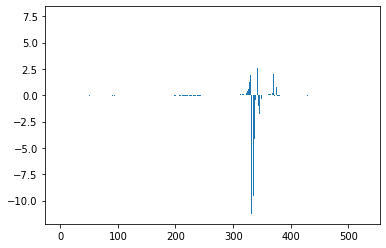

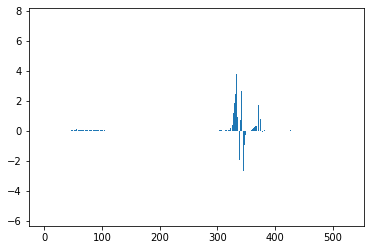

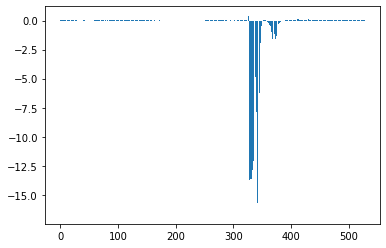

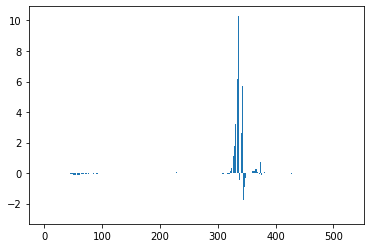

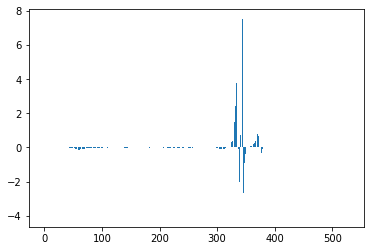

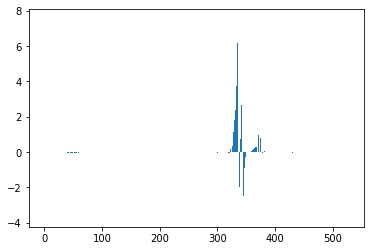

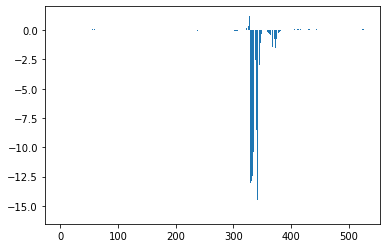

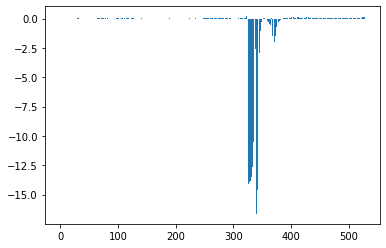

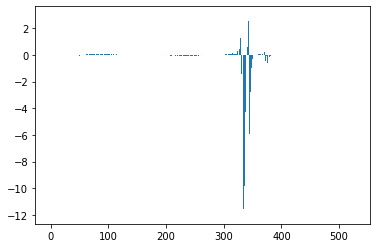

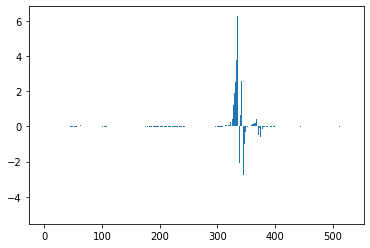

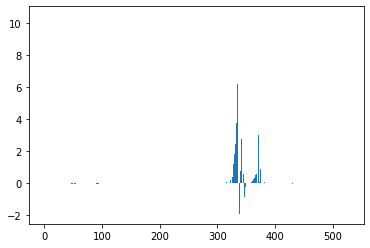

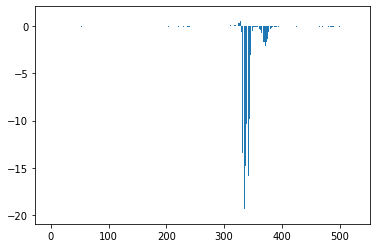

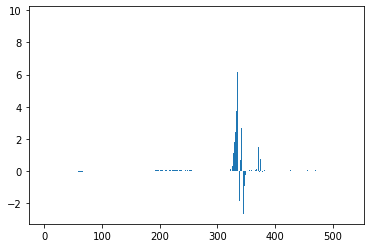

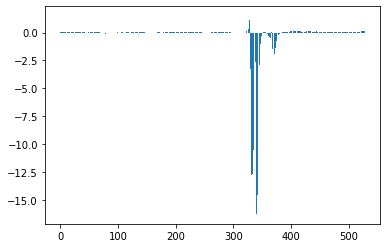

In [277]:
errors = [calculate_error(x, centroid) for x in X]
labels = calculate_faulty_parts(0.1, 2, errors, labels, 1)
plot_errors(errors, np.arange(0, len(errors), 1))

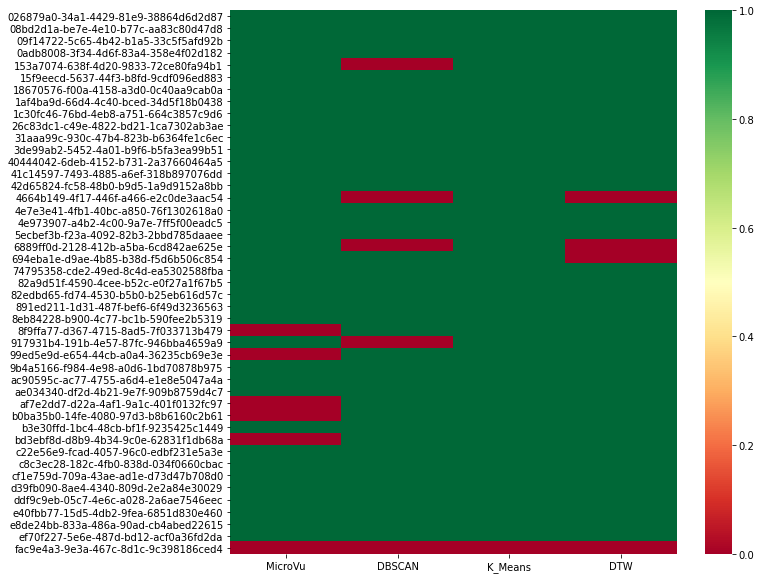

In [278]:
results = pd.Series(labels, index = instances)
results.sort_index(inplace = True)
heatmap_data['K_Means'] = results.values
plot_heatmap(heatmap_data)

## DTW Clustering

In [259]:
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesResampler

X_tsd = to_time_series_dataset(X)

#sz = 500
#X = TimeSeriesResampler(sz=sz).fit_transform(X_tsd)

fig, ax = plt.subplots(figsize=(15,10))
for series in X_tsd:
    ax.plot(series)
plt.show()

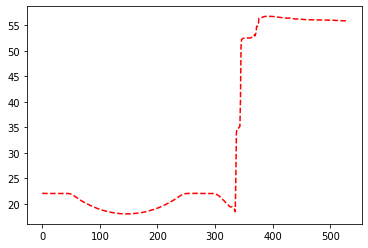

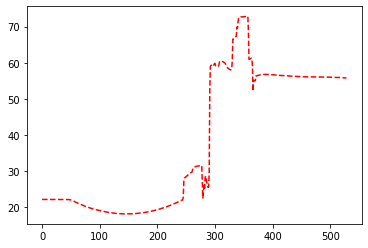

In [260]:
from tslearn.clustering import TimeSeriesKMeans

n_clusters = 2
model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=3)
labels = model.fit_predict(X_tsd)

for i in range(n_clusters):
    #for xx in X[labels == i]:
        #plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model.cluster_centers_[i].ravel(), "r--")
    plt.show()

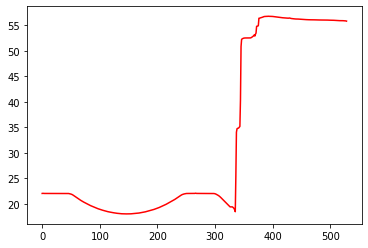

In [261]:
dtw_centroid = model.cluster_centers_[0].ravel()
plt.plot(dtw_centroid, "r-")

In [262]:
errors = [calculate_error(x, dtw_centroid) for x in X]
labels = calculate_faulty_parts(0.1, 2, errors, labels, 0)

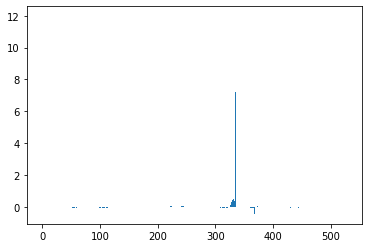

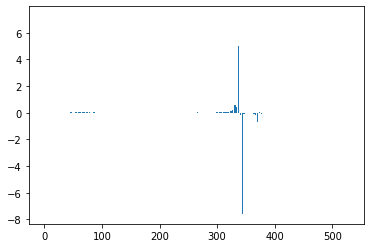

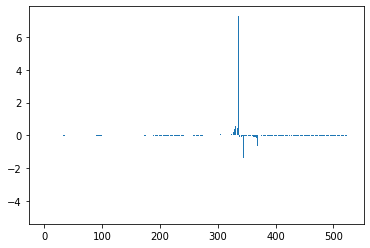

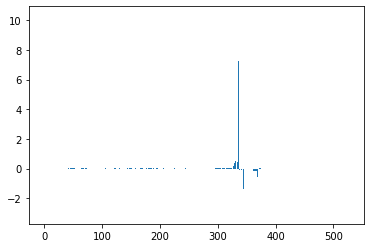

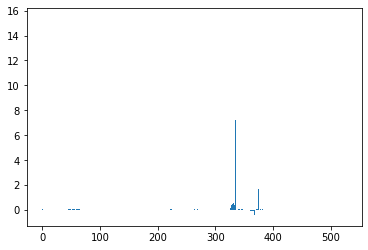

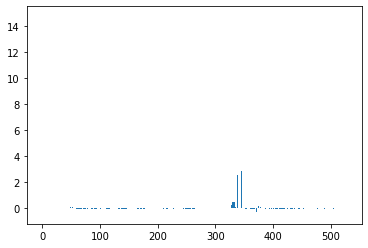

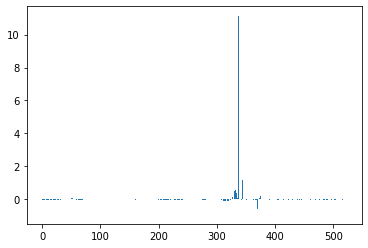

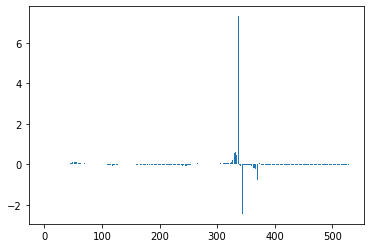

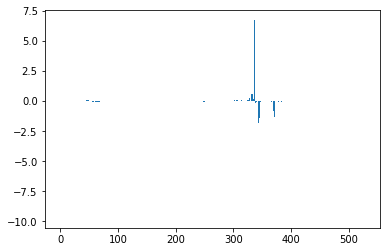

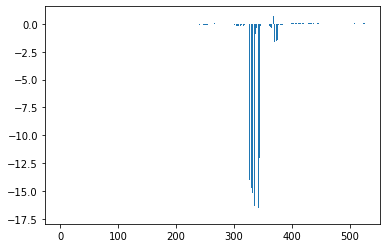

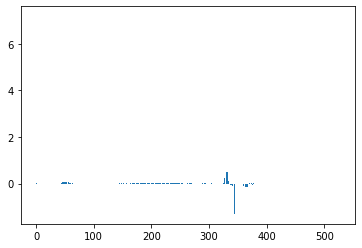

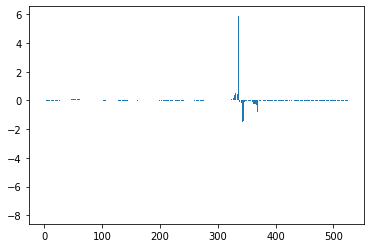

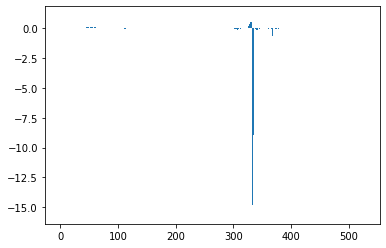

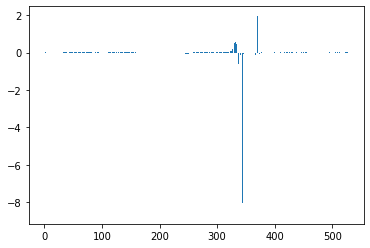

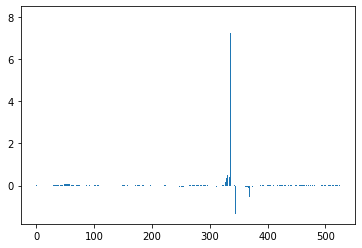

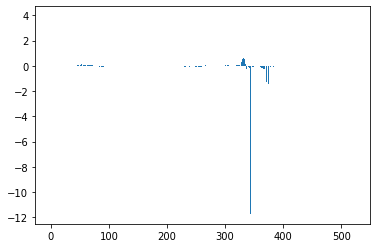

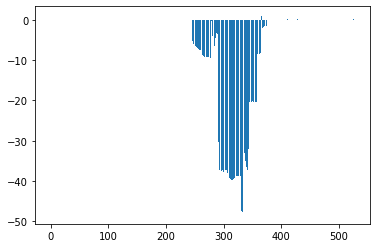

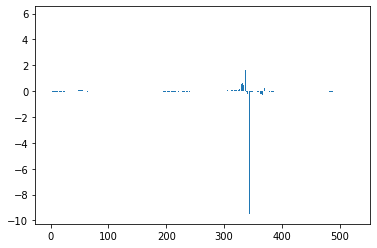

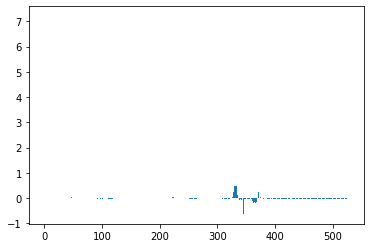

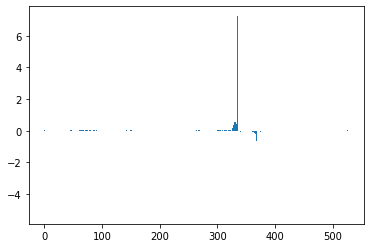

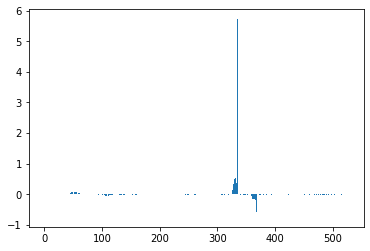

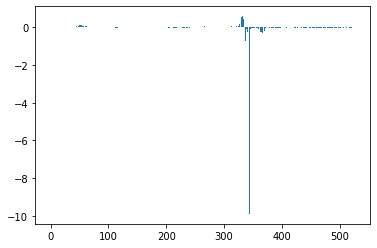

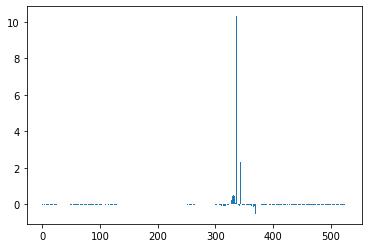

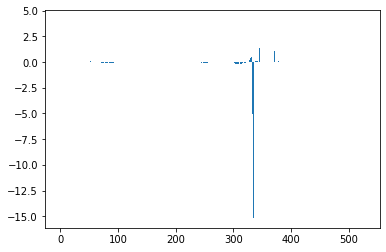

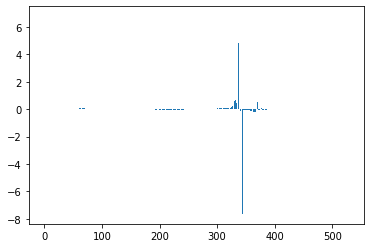

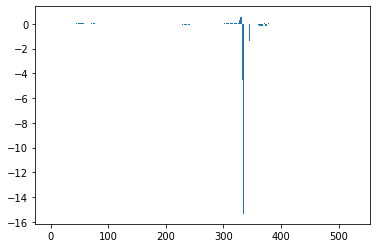

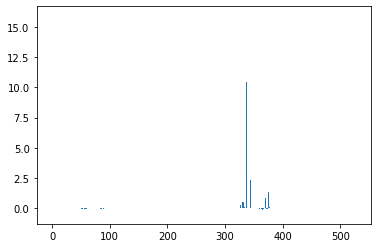

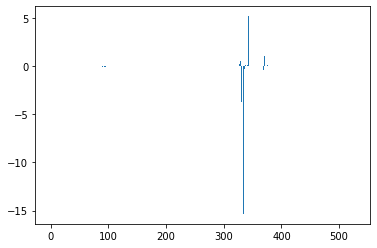

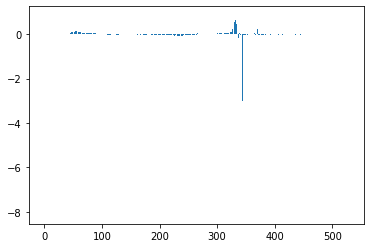

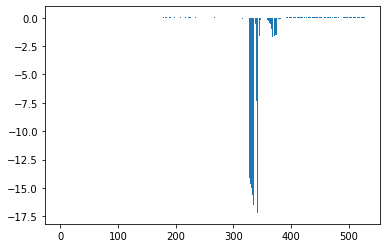

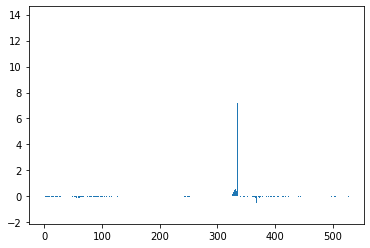

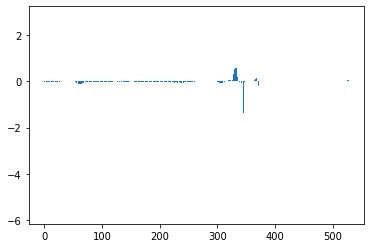

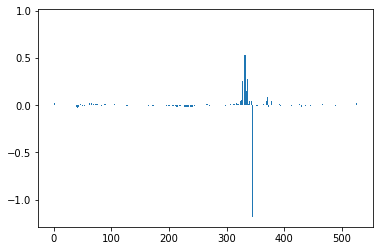

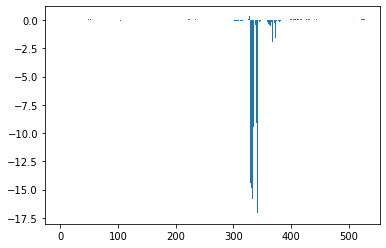

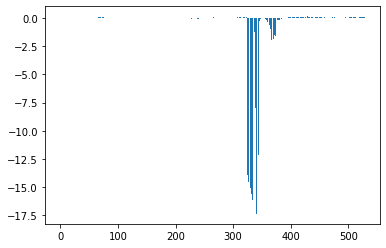

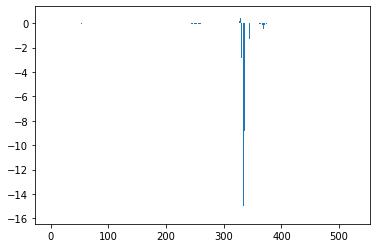

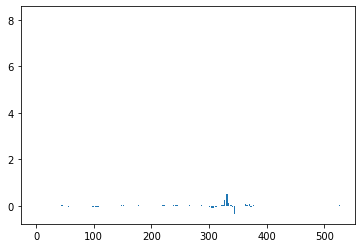

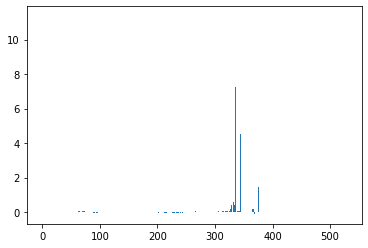

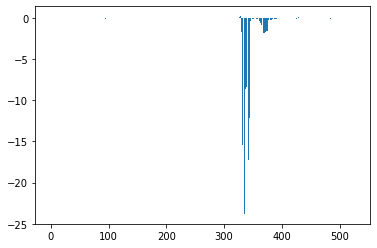

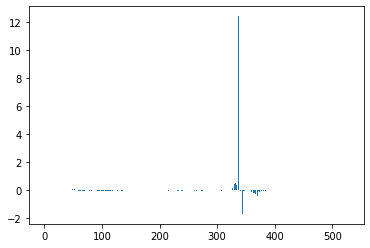

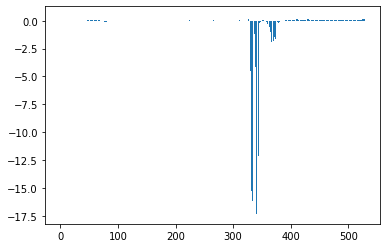

In [263]:
plot_errors(errors, np.arange(0, len(errors), 1))

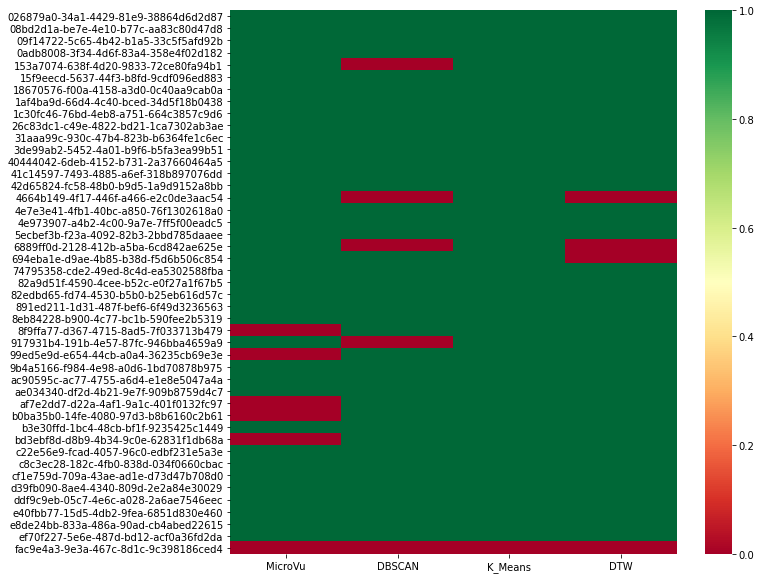

In [264]:
results = pd.Series(labels, index = instances)
results.sort_index(inplace = True)
heatmap_data['DTW'] = results.values
plot_heatmap(heatmap_data)